In [48]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
from xgboost import XGBClassifier
import seaborn as sns
import matplotlib.pyplot as plt

In [49]:
# Load data
df = pd.read_csv('train.csv')
df_events = df[df['class4'] != 'nonevent'].copy()
label_mapping = {'Ia': 0, 'Ib': 1, 'II': 2}
df_events['labels'] = df_events['class4'].map(label_mapping)

# Features and labels
# partlybad无用可去掉
X = df_events.drop(columns=['id', 'class4', 'labels', 'date', 'partlybad'])
y = df_events['labels']

# Split data into training and testing sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


# Logistic with $L_1$ Regularization

In [50]:
# Create a pipeline with scaling and logistic regression
pipe_multi = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(
        penalty='l1',
        solver='saga',  
        C=1.0,
        max_iter=10000,
        random_state=42
    ))
])

In [51]:
# Hyperparameter tuning using GridSearchCV
param_grid = {
    # 'clf__C': [0.01, 0.05, 0.1, 0.5, 1.0, 1.5, 2.0]
    # 'clf__C': np.arange(0.1, 0.6, 0.1)
    'clf__C': np.arange(0.01, 0.4, 0.01)
}
grid = GridSearchCV(pipe_multi, param_grid, cv=5, n_jobs=-1, verbose=1)
grid.fit(X, y)

# print best params
print("best params:", grid.best_params_)
print("best score:",grid.best_score_)

Fitting 5 folds for each of 39 candidates, totalling 195 fits
best params: {'clf__C': np.float64(0.08)}
best score: 0.5466666666666666


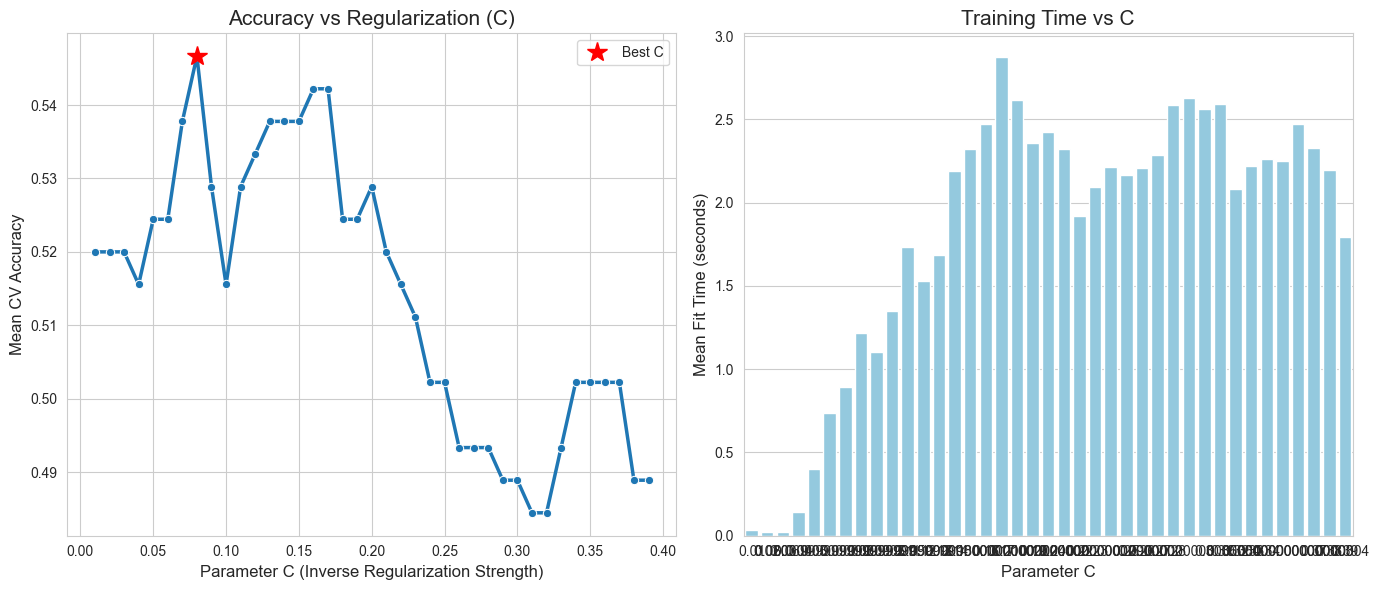

In [52]:
results_df = pd.DataFrame(grid.cv_results_)
results_df['C'] = results_df['param_clf__C']
results_df['Accuracy'] = results_df['mean_test_score']
results_df['Time'] = results_df['mean_fit_time']

# 设置绘图风格
sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# --- 图1: Accuracy vs C (折线图) ---
sns.lineplot(data=results_df, x='C', y='Accuracy', marker='o', linewidth=2.5, ax=axes[0])
axes[0].set_title('Accuracy vs Regularization (C)', fontsize=15)
axes[0].set_xlabel('Parameter C (Inverse Regularization Strength)', fontsize=12)
axes[0].set_ylabel('Mean CV Accuracy', fontsize=12)

# 标出最高点
best_row = results_df.loc[results_df['rank_test_score'] == 1].iloc[0]
axes[0].plot(best_row['C'], best_row['Accuracy'], 'r*', markersize=15, label='Best C')
axes[0].legend()

# --- 图2: Training Time vs C (条形图) ---
sns.barplot(data=results_df, x='C', y='Time', color='skyblue', ax=axes[1])
axes[1].set_title('Training Time vs C', fontsize=15)
axes[1].set_xlabel('Parameter C', fontsize=12)
axes[1].set_ylabel('Mean Fit Time (seconds)', fontsize=12)

plt.tight_layout()
plt.show()

In [53]:
# Train the model with the best parameters
pipe_multi = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(
        penalty='l1',
        solver='saga',  
        C=0.08,
        max_iter=10000,
        random_state=42
    ))
])
pipe_l1.fit(X_train, y_train)

# Evaluate the model
y_pred = pipe_l1.predict(X_valid)
y_prob = pipe_l1.predict_proba(X_valid)[:, 1]
print("Accuracy:", accuracy_score(y_valid, y_pred))

# Feature selection based on L1 regularization
coef = pipe_l1.named_steps['clf'].coef_[0]
selected_features = X.columns[coef != 0]
print("\nFeatures selected by L1 regularization:", len(selected_features))
print("Selected features by L1:", selected_features)

Accuracy: 0.4888888888888889

Features selected by L1 regularization: 1
Selected features by L1: Index(['T672.mean'], dtype='object')


In [54]:
X_selected = df_events[selected_features] 

pipe_multi_selected = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(
        penalty='l1',
        solver='saga',  
        C=1,
        max_iter=10000,
        random_state=42
    ))
])

pipe_multi_selected.fit(X_selected, y)

X_valid_selected = X_valid[selected_features]

y_pred = pipe_multi_selected.predict(X_valid_selected)
y_prob = pipe_multi_selected.predict_proba(X_valid_selected)

print("三分类 Accuracy:", accuracy_score(y_valid, y_pred))
print("三分类 ROC-AUC (OvR):", roc_auc_score(y_valid, y_prob, multi_class='ovr'))

三分类 Accuracy: 0.5111111111111111
三分类 ROC-AUC (OvR): 0.5812299465240641


In [55]:
# Predict on test set
df_test = pd.read_csv('binary_logistic.csv')
inverse_mapping = {0: 'Ia', 1: 'Ib', 2: 'II'}

event_mask = df_test['class4'] != 'nonevent'

X_test_events = df_test.loc[event_mask, selected_features]
y_pred_int = pipe_multi_selected.predict(X_test_events)
y_pred_str = [inverse_mapping[i] for i in y_pred_int]

df_test.loc[event_mask, 'class4'] = y_pred_str
df_triple_submission = df_test[['id', 'class4', 'p']]
df_triple_submission.to_csv('triple_logistic.csv', index=False)

print("=== 最终预测结果统计 ===")
counts = df_triple_submission['class4'].value_counts()
print(counts)


=== 最终预测结果统计 ===
class4
nonevent    513
II          445
Ia            7
Name: count, dtype: int64


# Random Forest

In [ ]:
# Random Forest with Hyperparameter Tuning
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Hayperparameter grid
param_grid = {
    'n_estimators': [200, 500],
    'max_depth': [None, 10, 20],
    'max_features': ['sqrt', 0.5, 1.0],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': [None, 'balanced']
}

grid = GridSearchCV(rf, param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=2)

grid.fit(X, y)
print(grid.best_params_)
print(grid.best_score_)

In [ ]:
# Train the Random Forest with the best parameters
rf = RandomForestClassifier(
    n_estimators=500,
    max_depth=10,          
    min_samples_split=2,
    min_samples_leaf=2,
    max_features='sqrt',     
    bootstrap=True,
    random_state=42,
    n_jobs=-1                
)

rf.fit(X_train, y_train)

In [ ]:
# Evaluate the Random Forest model
y_valid_pred = rf.predict(X_valid)
y_valid_prob = rf.predict_proba(X_valid)[:, 1]

print("Random Forest Accuracy:", accuracy_score(y_valid, y_valid_pred))
print("Random Forest AUC:", roc_auc_score(y_valid, y_valid_prob))

In [ ]:
# Predict on test set
df_test = pd.read_csv('test.csv')
X_test = df_test[selected_features]
y_test_prob_rf = pipe_l1_selected.predict_proba(X_test)[:, 1]

# Binary class hard prediction
y_test_pred_rf = (y_test_prob_rf >= 0.5).astype(int)

# Map to class4 (simple strategy: all events are considered Ia)
class4_pred = np.where(y_test_pred_rf == 1, 'Ia', 'nonevent')

submission_rf = pd.DataFrame({
    'id': df_test['id'],
    'class4': class4_pred,
    'p': y_test_prob_rf
})

submission_rf.to_csv('submission_rf.csv', index=False)

In [ ]:
# Obtain the important features from Random Forest
feature_importances = rf.feature_importances_
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': feature_importances
}).sort_values('importance', ascending=False)

print("Top 20 Most Important Features:")
print(importance_df.head(20))

# XGBoost

In [ ]:
# XGBoost Classifier
xgb = XGBClassifier(
    n_estimators=600,        
    max_depth=4,          
    learning_rate=0.03,     
    subsample=0.8,          
    colsample_bytree=0.8,  
    objective='binary:logistic',
    eval_metric='logloss',  
    random_state=42,
    n_jobs=-1
)

xgb.fit(X_train, y_train)

# Evaluate the XGBoost model
y_valid_prob = xgb.predict_proba(X_valid)[:, 1]
y_valid_pred = (y_valid_prob >= 0.5).astype(int)
print("Accuracy:", accuracy_score(y_valid, y_valid_pred))
print("AUC:", roc_auc_score(y_valid, y_valid_prob))
print("Log-loss:", log_loss(y_valid, y_valid_prob))

In [ ]:
# Predict on test set
df_test = pd.read_csv('test.csv')
X_test = df_test[selected_features]
y_test_prob_xgb = pipe_l1_selected.predict_proba(X_test)[:, 1]

# Binary class hard prediction
y_test_pred_xgb = (y_test_prob_xgb >= 0.5).astype(int)

# Map to class4 (simple strategy: all events are considered Ia)
class4_pred = np.where(y_test_pred_xgb == 1, 'Ia', 'nonevent')

submission_xgb = pd.DataFrame({
    'id': df_test['id'],
    'class4': class4_pred,
    'p': y_test_prob_xgb
})

submission_xgb.to_csv('submission_xgb.csv', index=False)

# SVM

In [ ]:
# Hyperparameter tuning for SVM with L1 regularization
param_grid = {'clf__C': [0.01, 0.05, 0.1, 0.5, 1.0]}

grid_svm = GridSearchCV(estimator=svm_l1, param_grid=param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=2)

grid_svm.fit(X, y)

print("Best params:", grid_svm.best_params_)
print("Best CV score:", grid_svm.best_score_)

In [ ]:
# Train the model with the best parameters
svm_l1 = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LinearSVC(penalty='l1', loss='squared_hinge', dual=False, C=0.1, max_iter=5000, random_state=42))
])

svm_l1.fit(X_train, y_train)

# Evaluate the model
y_valid_pred = svm_l1.predict(X_valid)
print("Accuracy:", accuracy_score(y_valid, y_valid_pred))
print("AUC (using decision_function):", 
      roc_auc_score(y_valid, svm_l1.decision_function(X_valid)))

# Selected features based on SVM with L1 regularization
coef = svm_l1.named_steps['clf'].coef_[0]
selected_features_svm = X.columns[coef != 0]
print("Number of selected features:", len(selected_features_svm))
print(selected_features_svm)

In [ ]:
# Retrain model with selected features
pipe_l1_selected = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', SVC(kernel='linear', C=1.0, probability=True, random_state=42))
])
pipe_l1_selected.fit(X[selected_features_svm], y)

# Evaluate the model
y_valid_pred = pipe_l1_selected.predict(X_valid[selected_features_svm])
print("Accuracy:", accuracy_score(y_valid, y_valid_pred))
print("AUC (using decision_function):", 
      roc_auc_score(y_valid, pipe_l1_selected.decision_function(X_valid[selected_features_svm])))

In [ ]:
# Predict on test set
df_test = pd.read_csv('test.csv')
X_test = df_test[selected_features_svm]

# Calibrated classifier for probability estimates
svm_l1_calibrated = CalibratedClassifierCV(estimator=pipe_l1_selected,method='sigmoid',cv=5)
svm_l1_calibrated.fit(X[selected_features_svm], y)
y_test_prob_svm = svm_l1_calibrated.predict_proba(X_test[selected_features_svm])[:, 1]

# Binary class hard prediction
y_test_pred_class2 = (y_test_prob_svm >= 0.5).astype(int)
class4_pred = np.where(y_test_pred_class2 == 1, 'Ia', 'nonevent')

submission_xgb = pd.DataFrame({
    'id': df_test['id'],
    'class4': class4_pred,
    'p': y_test_prob_svm
})

submission_xgb.to_csv('submission_svm.csv', index=False)